In [2]:
import pandas as pd
import numpy as np
import glob
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve, learning_curve, KFold, StratifiedKFold

In [3]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [4]:
start_time = time.time() 

In [5]:
asteroid_df = pd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df.drop(columns = ['diameter', 'albedo', 'a', 'i', 'neo'], inplace = True)
asteroid_df

,pha,H,e,q,n,moid,spkid,full_name
0,0,-7.411043,-0.608738,0.289176,-0.009788,0.306452,20000001,1 Ceres (A801 AA)
1,0,-6.932515,0.859223,-0.382876,-0.017945,-0.258065,20000002,2 Pallas (A802 FA)
2,0,-6.282209,1.108738,-0.618740,0.181077,-0.564516,20000003,3 Juno (A804 RA)
3,0,-7.466258,-0.503883,-0.357027,0.928222,-0.403226,20000004,4 Vesta (A807 FA)
4,0,-5.171779,0.440777,-0.444265,0.384992,-0.451613,20000005,5 Astraea (A845 XA)
...,...,...,...,...,...,...,...,...
137912,0,-3.141104,8.195146,6.101777,-3.502333,6.048387,3547316,(2010 BK118)
137913,0,-0.319018,7.751456,2.129241,-3.470979,2.258065,3516402,(2010 GW64)
137914,0,-1.306748,8.038835,4.859451,-3.497338,5.290323,3517549,(2010 GW147)
137915,0,-0.503067,7.960194,0.447496,-3.476215,0.903226,3523334,(2010 JH124)


In [6]:
print(asteroid_df.dtypes)

pha            int64
H            float64
e            float64
q            float64
n            float64
moid         float64
spkid          int64
full_name     object
dtype: object


## Split data

In [7]:
exclude_col = ['pha', 'spkid', 'full_name']
X = asteroid_df.drop(columns = exclude_col)
y = asteroid_df.iloc[:, 0]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [9]:
X_train.shape, y_train.shape

((110333, 5), (110333,))

In [10]:
X_test.shape, y_test.shape

((27584, 5), (27584,))

In [11]:
X_train.describe()

,H,e,q,n,moid
count,110333.000000,110333.000000,110333.000000,110333.000000,110333.000000
mean,-0.050451,0.073256,0.056583,0.056455,0.053393
std,0.872397,0.790674,0.836323,0.972270,0.825449
min,-7.466258,-1.374757,-3.696284,-3.502333,-2.241661
25%,-0.503067,-0.484466,-0.479806,-0.557912,-0.483871
50%,0.000000,0.000971,0.004847,-0.003263,0.000000
75%,0.490798,0.516505,0.516963,0.440457,0.500000
max,7.411043,8.195146,48.597738,28.942904,48.403226


## logistic regression model

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="lbfgs", multi_class="auto")

logreg.fit(X_train, y_train)    # Train the model using the training sets

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='auto')

In [13]:
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, logreg.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, logreg.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.998795,0.998187


In [14]:
# Predict on the test data set
y_pred = logreg.predict(X_test)

In [15]:
logreg.predict(X_test)[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

#### Model slop and intercept

In [16]:
print("Number of coefficients:", len(logreg.coef_))
print("Estimated coefficients: {}".format(logreg.coef_))
print("Estimated intercept: {}".format(logreg.intercept_))

Number of coefficients: 1
Estimated coefficients: [[-0.36361722 -0.64835097 -3.3524612  -0.17468256 -9.49943146]]
Estimated intercept: [-25.47663853]


### Evaluate logistic regression model

In [17]:
target_names = ['non-PHA', 'PHA']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     non-PHA       1.00      1.00      1.00     27511
         PHA       0.83      0.40      0.54        73

    accuracy                           1.00     27584
   macro avg       0.91      0.70      0.77     27584
weighted avg       1.00      1.00      1.00     27584



In [18]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[27505,     6],
       [   44,    29]], dtype=int64)

#### RMS

In [19]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE value : {:.2f}".format(rmse))

RMSE value : 0.04


#### Model slop and intercept

#### R2

In [20]:
print("R2 Score value: {:.2f}".format(r2_score(y_test, y_pred)))

R2 Score value: 0.31


In [21]:
print("Training set score: {:.2f}".format(logreg.score(X_train, y_train)))

Training set score: 1.00


In [22]:
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 1.00


#### Cross-validation

In [23]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(logreg, X, y, cv=5)

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: Futur

In [24]:
# print the 5-fold cross-validation scores
print(cv_scores.round(4))

[0.9992 0.9988 0.9985 0.9981 0.9687]


In [25]:
# print the avarage 5-fold cross-validation scores
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores).round(4)))

Average 5-Fold CV Score: 0.9927


### Plotting Residual Error

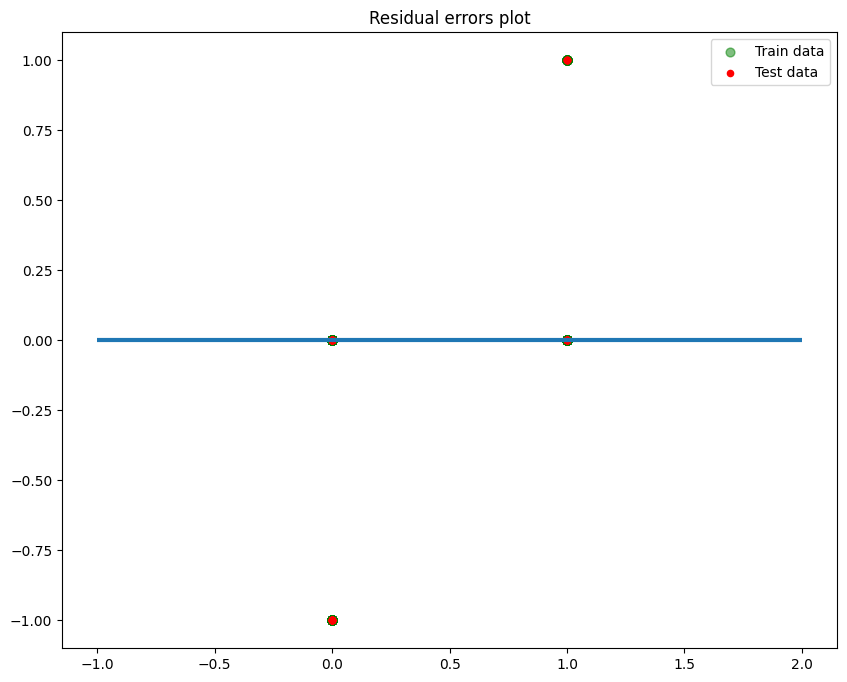

In [26]:
%matplotlib inline
plt.figure(figsize=(10,8))

# plotting residual errors in training data
plt.scatter(logreg.predict(X_train), logreg.predict(X_train) - y_train, c = 'g', s = 40, label = 'Train data', alpha = 0.5)

# plotting residual errors in test data
plt.scatter(logreg.predict(X_test), logreg.predict(X_test) - y_test, c = 'r', s = 20, label = 'Test data')

# plotting line for zero residual error
plt.hlines(y = 0, xmin = -1, xmax = 2, linewidth = 3)

# plotting legend
plt.legend(loc = 'upper right')

# plot title
plt.title("Residual errors plot")

# function to show plot
plt.show()

In [27]:
target_names = ['non-PHA', 'PHA']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     non-PHA       1.00      1.00      1.00     27511
         PHA       0.83      0.40      0.54        73

    accuracy                           1.00     27584
   macro avg       0.91      0.70      0.77     27584
weighted avg       1.00      1.00      1.00     27584



In [28]:
precision_metric_macro = precision_score(y_test, y_pred, average = "macro")
recall_metric_macro = recall_score(y_test, y_pred, average = "macro")
accuracy_metric = accuracy_score(y_test, y_pred)
f1_metric_macro = f1_score(y_test, y_pred, average = "macro")
    
print('Precision metric:',round(precision_metric_macro, 2))
print('Recall Metric:',round(recall_metric_macro, 2))
print('Accuracy Metric:',round(accuracy_metric, 4))
print('F1 score:',round(f1_metric_macro, 2))

Precision metric: 0.91
Recall Metric: 0.7
Accuracy Metric: 0.9982
F1 score: 0.77


In [29]:
precision_metric_micro = precision_score(y_test, y_pred, average = "micro")
recall_metric_micro = recall_score(y_test, y_pred, average = "micro")
f1_metric_micro = f1_score(y_test, y_pred, average = "micro")
    
print('Precision metric:',round(precision_metric_micro, 2))
print('Recall Metric:',round(recall_metric_micro, 2))
print('F1 score:',round(f1_metric_micro, 2))

Precision metric: 1.0
Recall Metric: 1.0
F1 score: 1.0


In [30]:
precision_metric_weighted = precision_score(y_test, y_pred, average = "weighted")
recall_metric_weighted = recall_score(y_test, y_pred, average = "weighted")
f1_metric_weighted = f1_score(y_test, y_pred, average = "weighted")
    
print('Precision metric:',round(precision_metric_weighted, 2))
print('Recall Metric:',round(recall_metric_weighted, 2))
print('F1 score:',round(f1_metric_weighted, 2))

Precision metric: 1.0
Recall Metric: 1.0
F1 score: 1.0


### Q-Q Plot

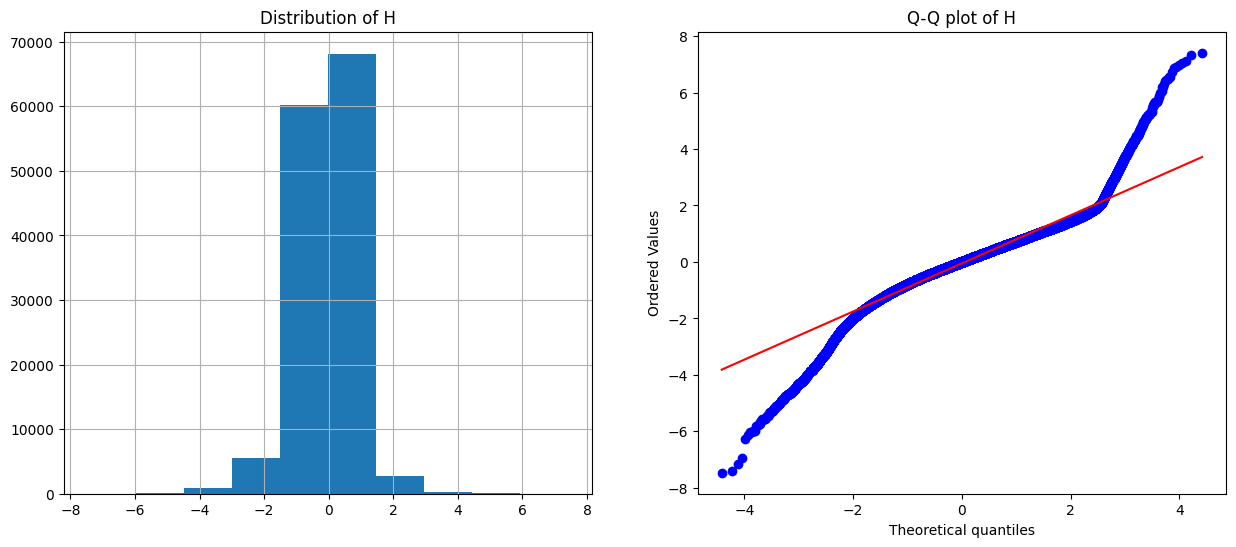

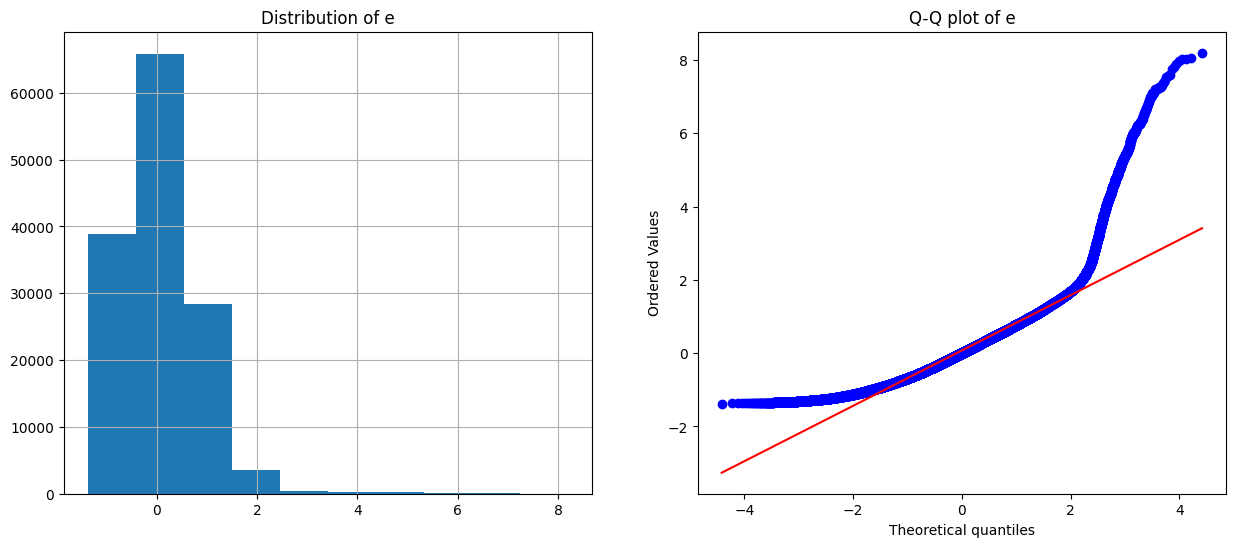

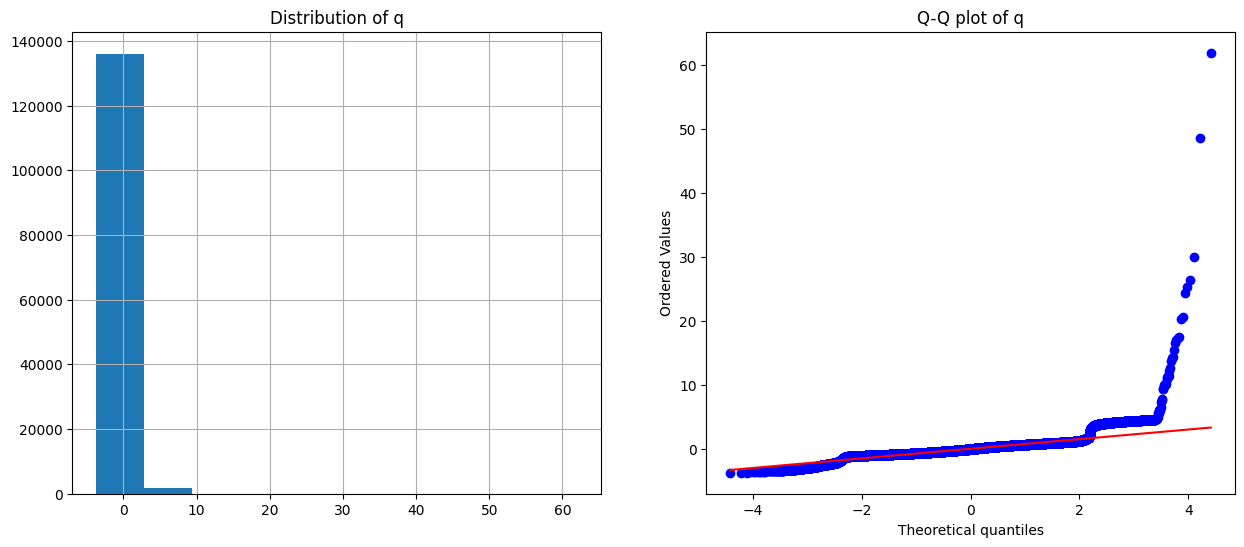

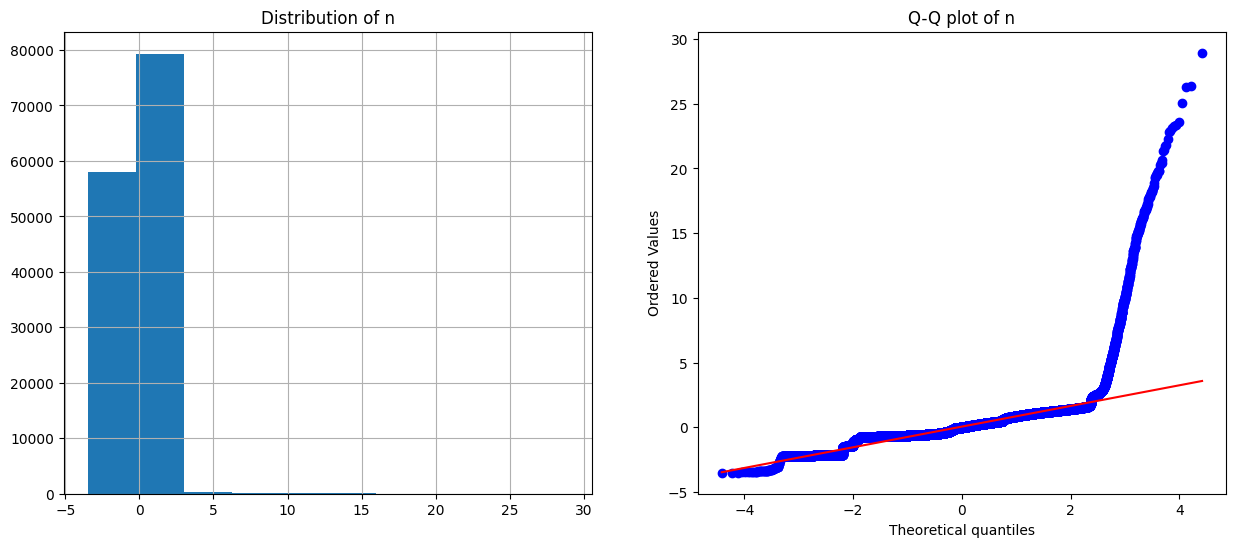

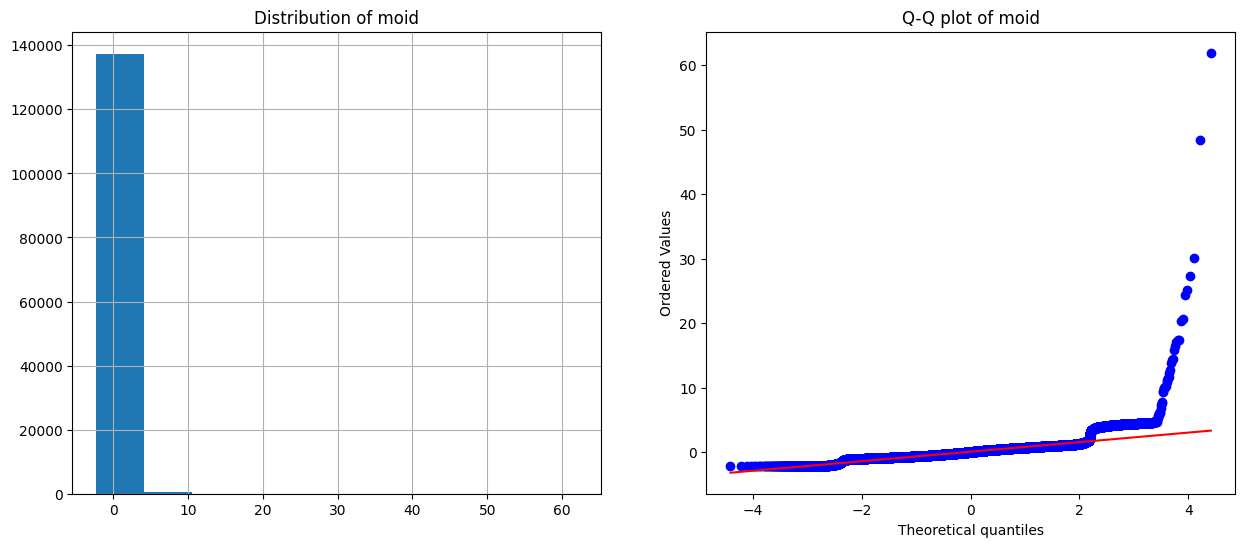

In [31]:
import pylab 
import scipy.stats as stats

exclude_col = ['pha', 'spkid', 'full_name']
asteroid_plot = asteroid_df.drop(columns = exclude_col)         

for var in asteroid_plot.columns:
        plt.figure(figsize=(15, 6))

        # Histogram of the variable
        plt.subplot(1, 2, 1)
        asteroid_df[var].hist()
        plt.title('Distribution of ' + var)

        # Q-Q plot for normality
        plt.subplot(1, 2, 2)
        stats.probplot(asteroid_df[var], dist="norm", plot=pylab)
        plt.title('Q-Q plot of ' + var)

        # Display the plots
        plt.show()

# Using SMOTE to Even out Data Set

In [32]:
sm = SMOTE(random_state = 42) 
X_train_over, y_train_over = sm.fit_resample(X_train, y_train.ravel())

C:\Users\stack\AppData\Local\Temp\ipykernel_26700\1757892739.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_over, y_train_over = sm.fit_resample(X_train, y_train.ravel())


In [33]:
logreg2 = LogisticRegression()   # instantiate an object lr

logreg2.fit(X_train_over, y_train_over)    # Train the model using the training sets

LogisticRegression()

In [34]:
# Predict on the test data set
y_pred2 = logreg2.predict(X_test)

In [35]:
logreg2.predict(X_test)[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [36]:
print("Number of coefficients:", len(logreg2.coef_))
print("Estimated coefficients: {}".format(logreg2.coef_))
print("Estimated intercept: {}".format(logreg2.intercept_))

Number of coefficients: 1
Estimated coefficients: [[ -0.59385138  -0.18664779  -0.69213746  -0.03447168 -29.83719561]]
Estimated intercept: [-59.36271466]


### Evaluate logistic regression model

#### RMS

In [37]:
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
print("RMSE value : {:.2f}".format(rmse))

RMSE value : 0.06


#### R2

In [38]:
print("R2 Score value: {:.2f}".format(r2_score(y_test, y_pred2)))

R2 Score value: -0.41


In [39]:
print("Training set score: {:.2f}".format(logreg2.score(X_train_over, y_train_over)))

Training set score: 1.00


In [40]:
print("Test set score: {:.2f}".format(logreg2.score(X_test, y_test)))

Test set score: 1.00


#### Cross-validation

In [41]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(logreg2, X, y, cv=5)

In [42]:
# print the 5-fold cross-validation scores
print(cv_scores.round(4))

[0.9992 0.9988 0.9985 0.9981 0.9687]


In [43]:
# print the avarage 5-fold cross-validation scores
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores).round(4)))

Average 5-Fold CV Score: 0.9927


In [44]:
print(metrics.confusion_matrix(y_test, y_pred2))

[[27408   103]
 [    0    73]]


In [45]:
precision_metric_macro = precision_score(y_test, y_pred2, average = "macro")
recall_metric_macro = recall_score(y_test, y_pred2, average = "macro")
accuracy_metric = accuracy_score(y_test, y_pred2)
f1_metric_macro = f1_score(y_test, y_pred2, average = "macro")
    
print('Precision metric:',round(precision_metric_macro, 2))
print('Recall Metric:',round(recall_metric_macro, 2))
print('Accuracy Metric:',round(accuracy_metric, 4))
print('F1 score:',round(f1_metric_macro, 2))

Precision metric: 0.71
Recall Metric: 1.0
Accuracy Metric: 0.9963
F1 score: 0.79


In [46]:
precision_metric_micro = precision_score(y_test, y_pred2, average = "micro")
recall_metric_micro = recall_score(y_test, y_pred2, average = "micro")
f1_metric_micro = f1_score(y_test, y_pred2, average = "micro")
    
print('Precision metric:',round(precision_metric_macro, 2))
print('Recall Metric:',round(recall_metric_micro, 2))
print('F1 score:',round(f1_metric_micro, 2))

Precision metric: 0.71
Recall Metric: 1.0
F1 score: 1.0


In [47]:
precision_metric_weighted = precision_score(y_test, y_pred2, average = "weighted")
recall_metric_weighted = recall_score(y_pred2, y_pred, average = "weighted")
f1_metric_weighted = f1_score(y_test, y_pred2, average = "weighted")
    
print('Precision metric:',round(precision_metric_weighted, 2))
print('Recall Metric:',round(recall_metric_weighted, 2))
print('F1 score:',round(f1_metric_weighted, 2))

Precision metric: 1.0
Recall Metric: 0.99
F1 score: 1.0


### Plotting Residual Error

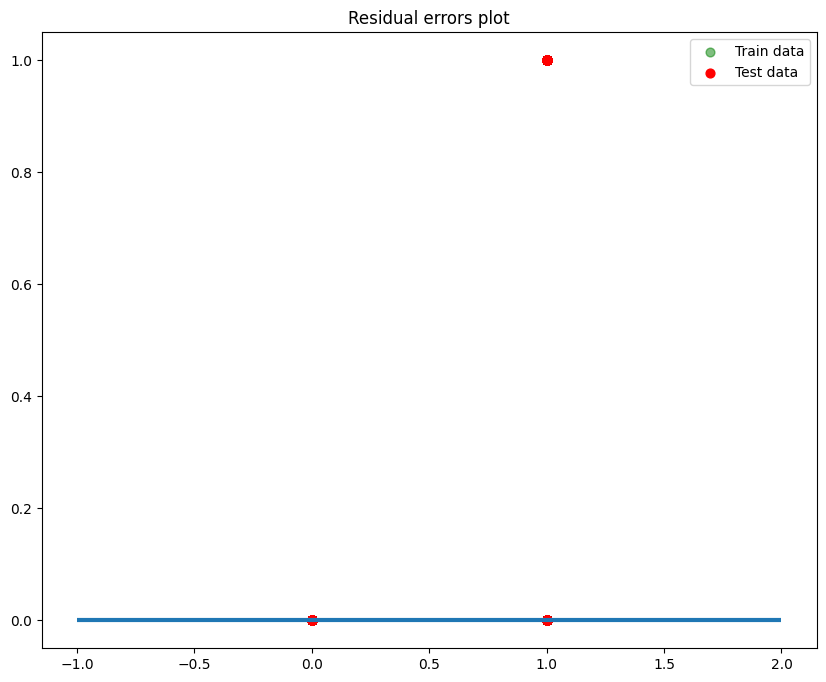

In [48]:
%matplotlib inline
plt.figure(figsize=(10,8))

# plotting residual errors in training data
plt.scatter(logreg2.predict(X_train_over), logreg2.predict(X_train_over) - y_train_over, c = 'g', s = 40, label = 'Train data', alpha = 0.5)

# plotting residual errors in test data
plt.scatter(logreg2.predict(X_test), logreg2.predict(X_test) - y_test, c = 'r', s = 40, label = 'Test data')

# plotting line for zero residual error
plt.hlines(y = 0, xmin = -1, xmax = 2, linewidth = 3)

# plotting legend
plt.legend(loc = 'upper right')

# plot title
plt.title("Residual errors plot")

# function to show plot
plt.show()

## Validation in Practice: Grid Search

In [69]:
param_grid = {
    'penalty': ['l2', 'elasticnet'],  # Regularization penalty types
    'C': [ 1, 10, 20],  # Regularization strength (inverse)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Solvers for optimization
    'max_iter': [300, 500],  # Maximum number of iterations for convergence
    'l1_ratio': [0, 0.5, 1]  # Only used with 'elasticnet' penalty
}

# Initialize logistic regression model
logreg = LogisticRegression()

# Initialize GridSearchCV with logistic regression and the parameter grid
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 5)

In [70]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
start_time = time.time() 
grid_search.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")       #Execution time: 318.95 seconds

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Execution time: 318.95 seconds


In [71]:
### n_jobs = none
start_time = time.time() 
grid_search.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")  # Execution time: 689.96 seconds n_jobs = none (1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=newton-cg;, score=0.998 total time=   0.1s
[CV 2/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=newton-cg;, score=0.999 total time=   0.1s
[CV 3/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=newton-cg;, score=0.999 total time=   0.1s
[CV 4/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=newton-cg;, score=0.998 total time=   0.1s
[CV 5/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=newton-cg;, score=0.999 total time=   0.1s
[CV 1/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=lbfgs;, score=0.999 total time=   0.0s
[CV 2/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=lbfgs;, score=0.999 total time=   0.0s
[CV 3/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=lbfgs;, score=0.999 total time=   0.0s
[CV 4/5] END C=1, l1_ratio=0, max_iter=300, penalty=l2, solver=lbfgs;, score=0.999 total time=   0.0s

In [52]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 20, 'l1_ratio': 0, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Cross-Validation Score: 0.9992658597946464


In [53]:
logreg_best = LogisticRegression(penalty = 'l2', C = 20, max_iter =  300, solver = 'newton-cg')

## Heatmap for Hyperparameter Grid Search Results

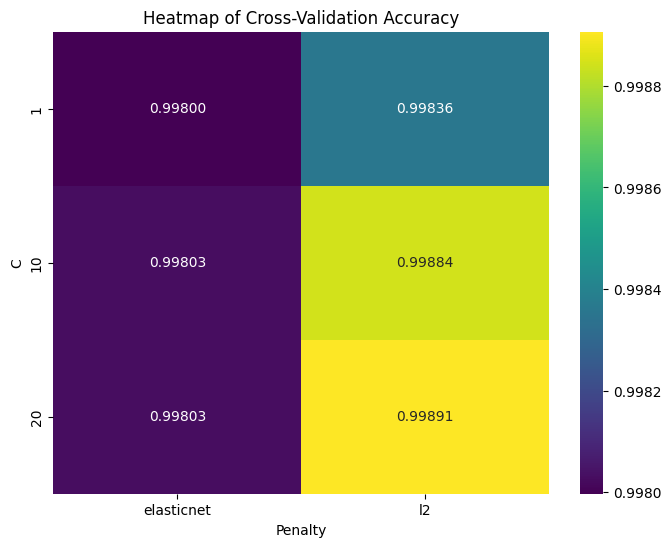

In [54]:
# Assuming grid_search.cv_results_ is available after running GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
grouped_results = results.groupby(["param_C", "param_penalty"])["mean_test_score"].mean().reset_index()

# Pivot to create the scores matrix
scores_matrix = grouped_results.pivot(index="param_C", columns="param_penalty", values="mean_test_score")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".5f", cmap="viridis")
plt.title("Heatmap of Cross-Validation Accuracy")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.show()


## Validation Curve (for a Single Hyperparameter)

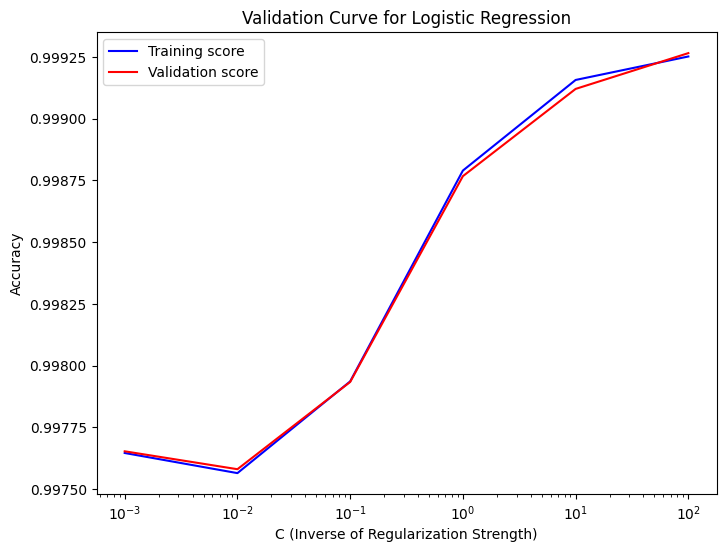

In [55]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, val_scores = validation_curve(
    LogisticRegression(),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation score", color="red")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.xscale("log")  # Log scale for C
plt.legend()
plt.show()

## Learning Curves (Training vs. Cross-Validation Performance)

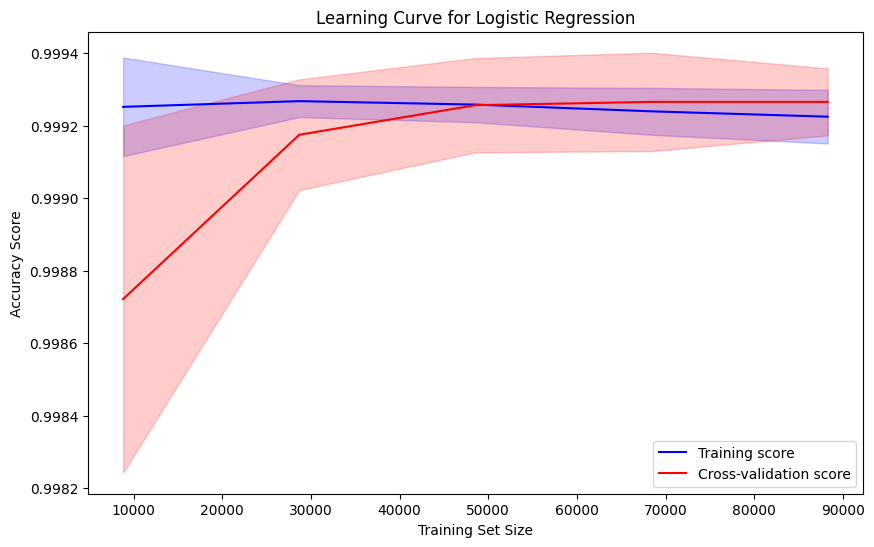

In [56]:
train_sizes, train_scores, val_scores = learning_curve(
    logreg_best, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
)

# Mean and standard deviation for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

### Model validation via cross-validation

In [57]:
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
logreg.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = logreg.predict(X2)
accuracy_score(y2, y2_model)

0.9986368711843269

In [58]:
y2_model = logreg.fit(X1, y1).predict(X2)
y1_model = logreg.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.9982308071579802, 0.9986368711843269)

In [59]:
cross_val_score(logreg, X, y, cv=5)

array([0.99920244, 0.99883991, 0.99851358, 0.99807853, 0.96867636])

In [60]:
skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=skf)
scores

#With 9 splits
#array([0.99869494, 0.99869486, 0.99895589, 0.99876011, 0.9990864 ,
#       0.99895589, 0.9990864 , 0.99876011, 0.99869486])
#With 25 splits
#array([0.99927497, 0.99818742, 0.99945623, 0.99891245, 0.99800616,
#       0.99927497, 0.99836868, 0.99873119, 0.99873119, 0.99873119,
#       0.99836868, 0.99927497, 0.99873119, 0.99873119, 0.99945623,
#       0.99854994, 0.99854994, 0.99927484, 0.99891226, 0.99891226,
#       0.99818709, 0.99927484, 0.99909355, 0.99873096, 0.99891226])

array([0.99869494, 0.99869486, 0.99895589, 0.99876011, 0.9990864 ,
       0.99895589, 0.9990864 , 0.99876011, 0.99869486])

In [61]:
scores.mean()
#With 9 Splits
#0.9988543845895842
#With 25 Splits
#0.9988253855214215

0.9988543845895842

## Cross Validation without KFold

In [62]:
kf = KFold(n_splits=55, shuffle=True, random_state=42)  
scores = cross_val_score(logreg, X, y, cv=kf)

In [63]:
scores.mean()
#With 5 Splits
#0.9987818807344852
#With 55 Splits
#0.9988761292941168

0.9988761292941168

In [64]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
#Execution time: 336.20 seconds with n_jobs = -2

Execution time: 336.20 seconds
